In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
"""Load data"""
USE_TF_MNIST = True
# Keras' MNIST causes problems with exploding gradients

if USE_TF_MNIST:
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)
    X_train, y_train, X_test, y_test = \
        mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
else:
    from keras.datasets import mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data(path="mnist.npz")

    # One-hot encode y_train and y_test
    y_train = np.array([np.array([0.]*(y)+[1.]+[0.]*(num_classes-y-1)) for y in y_train])
    y_test  = np.array([np.array([0.]*(y)+[1.]+[0.]*(num_classes-y-1)) for y in y_test])

    # Flatten Xs
    X_train = np.array([X.flatten() for X in X_train])
    X_test  = np.array([X.flatten() for X in X_test])


# Create placeholders
num_classes = 10 # 0 through 9
input_size = X_train.shape[1]
X = tf.placeholder("float", [None, input_size])
y = tf.placeholder("float", [None, num_classes])

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [63]:
"""Hyperparams"""

BATCH_SIZE = 128
EPOCHS = 15
LEARNING_RATE = 0.01
DROPOUT = 0.75 # Only used for ConvNets
ACC_EVERY = 1 # Print accuracy every __

In [38]:
"""Utility functions"""

activation = tf.nn.relu

def init_weights(weights_sizes):
    return [tf.Variable(tf.random_normal(weight_size))
           for weight_size in weights_sizes]

def init_biases(biases_sizes):
    return [tf.Variable(tf.random_normal([bias_size])) for bias_size in biases_sizes]

def fully_connected(prev_layer, weight, bias, activation=activation):
    layer = tf.add(tf.matmul(prev_layer, weight), bias)
    layer = activation(layer)
    return layer

def convolution(X, W, b, stride=1):
    X = tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='SAME')
    X = tf.nn.bias_add(X, b)
    return activation(X)

def max_pool(X):
    return tf.nn.max_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def autoencode_X(sess, decoder, x, autoencode=False):
    if autoencode:
        return sess.run(decoder, feed_dict={X: x})
    else:
        return x

Epoch  000  | Cost  0.174547  |  Testing Acc  0.156488


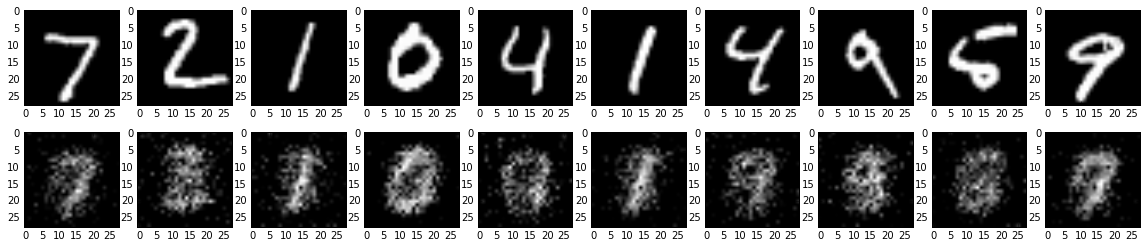

Epoch  001  | Cost  0.174547  |  Testing Acc  0.156488


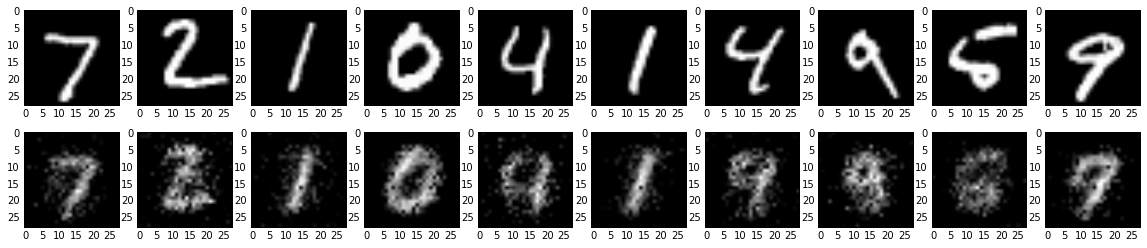

Epoch  002  | Cost  0.174547  |  Testing Acc  0.156488


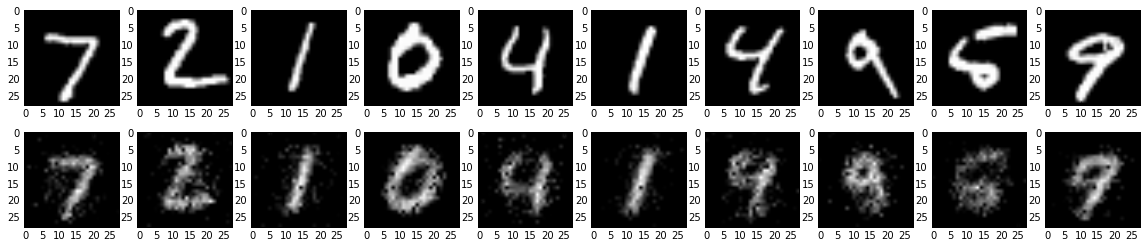

Epoch  003  | Cost  0.174547  |  Testing Acc  0.156488


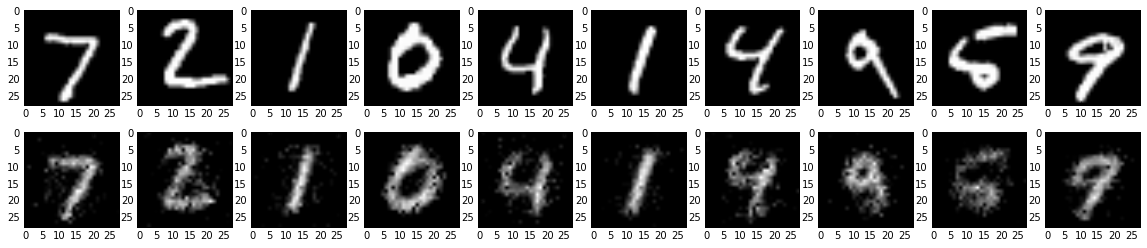

Epoch  004  | Cost  0.174547  |  Testing Acc  0.156488


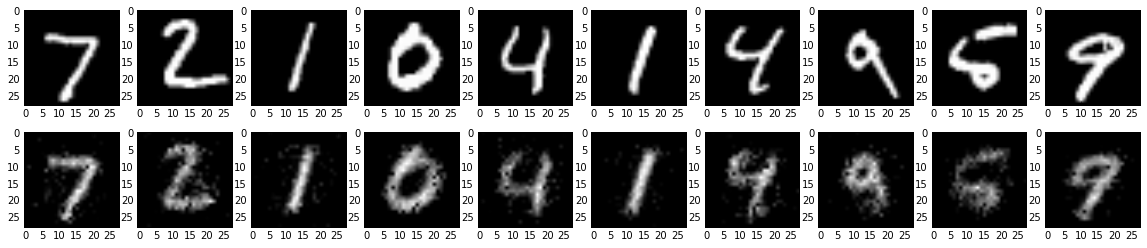

Epoch  005  | Cost  0.174547  |  Testing Acc  0.156488


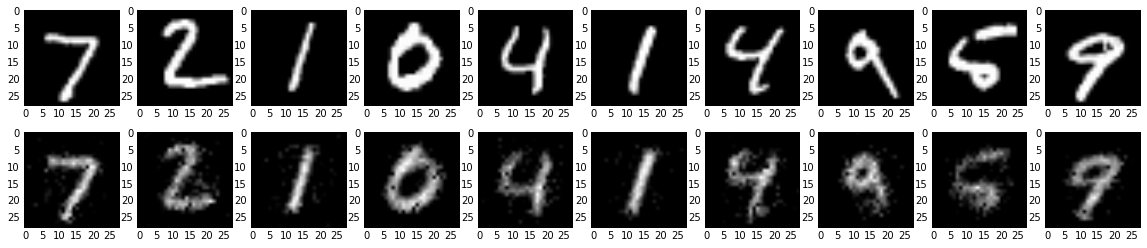

Epoch  006  | Cost  0.174547  |  Testing Acc  0.156488


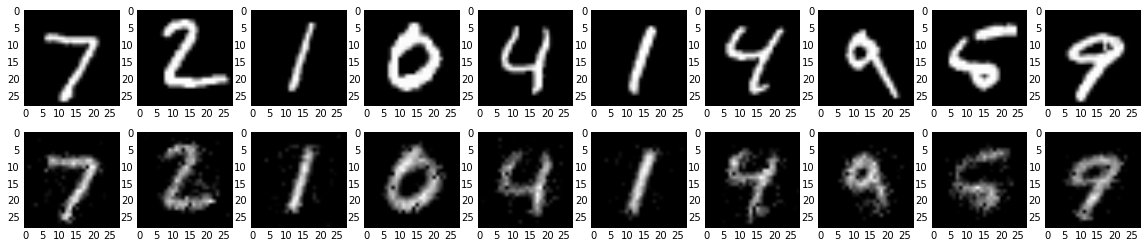

Epoch  007  | Cost  0.174547  |  Testing Acc  0.156488


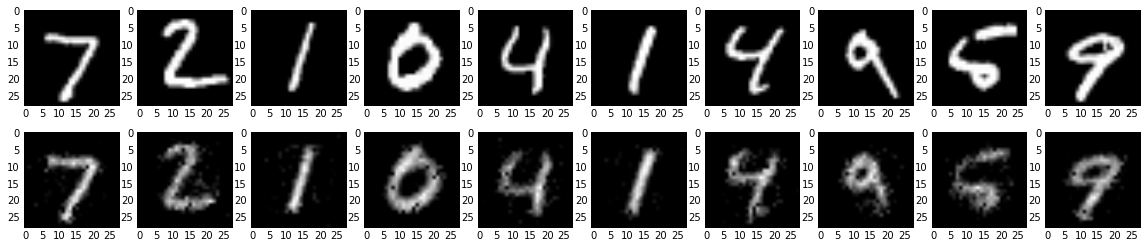

Epoch  008  | Cost  0.174547  |  Testing Acc  0.156488


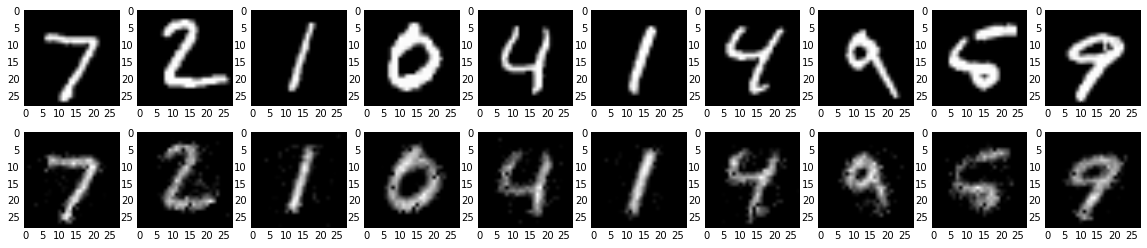

Epoch  009  | Cost  0.174547  |  Testing Acc  0.156488


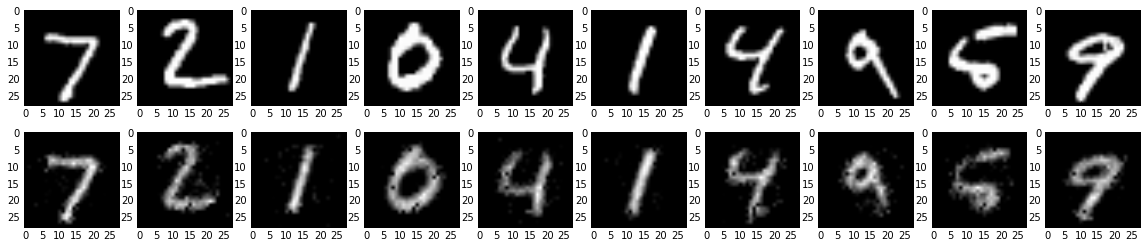

Epoch  010  | Cost  0.174547  |  Testing Acc  0.156488


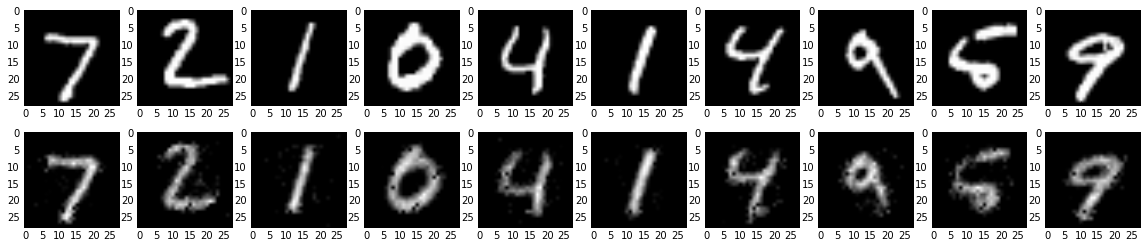

Epoch  011  | Cost  0.174547  |  Testing Acc  0.156488


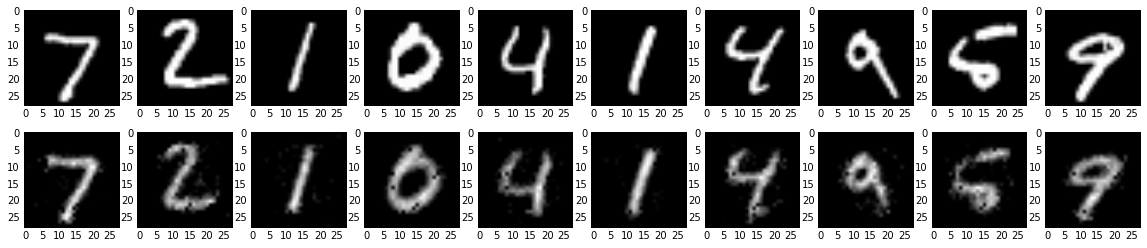

Epoch  012  | Cost  0.174547  |  Testing Acc  0.156488


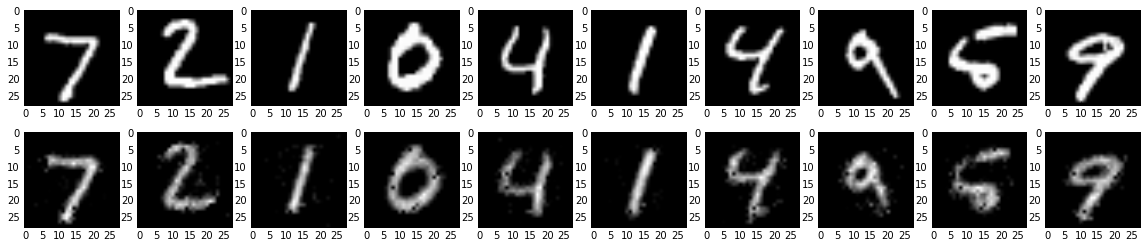

Epoch  013  | Cost  0.174547  |  Testing Acc  0.156488


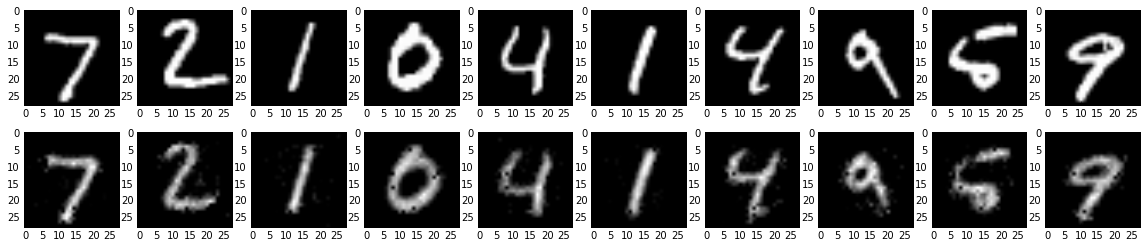

Epoch  014  | Cost  0.174547  |  Testing Acc  0.156488


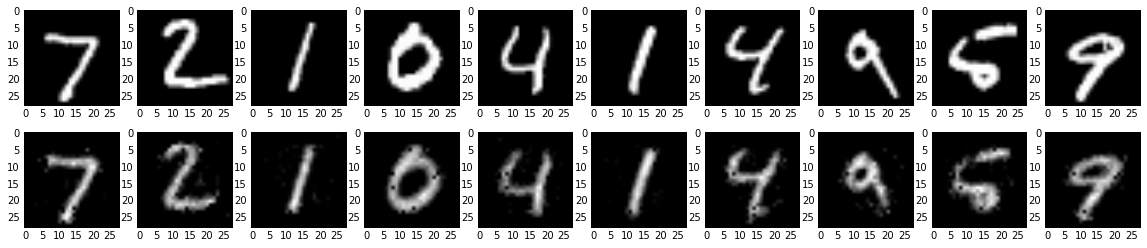

In [74]:
VIS_DECODE = True
encode_sizes = [input_size, 500]
decode_sizes = encode_sizes[::-1]

encode_weights = [tf.Variable(tf.random_normal([inp, out], mean=0.0, stddev=0.05)) \
                  for inp, out in zip(encode_sizes[:-1], encode_sizes[1:])]
decode_weights = [tf.Variable(tf.random_normal([inp, out], mean=0.0, stddev=0.05)) \
                  for inp, out in zip(decode_sizes[:-1], decode_sizes[1:])]

encode_biases = [tf.Variable(tf.zeros([out])) for out in encode_sizes[1:]]
decode_biases = [tf.Variable(tf.zeros([out])) for out in decode_sizes[1:]]

def create_encoder(x):
    layers = [x]
    for weight, bias in zip(encode_weights, encode_biases):
        layers.append(activation(tf.add(tf.matmul(
            layers[-1], weight), bias)))
    return layers[-1]


def create_decoder(x):
    layers = [x]
    for weight, bias in zip(decode_weights, decode_biases):
        layers.append(activation(tf.add(tf.matmul(
            layers[-1], weight), bias)))
    return layers[-1]


encoder = create_encoder(X)
decoder = create_decoder(encoder)

r2 = tf.reduce_mean(tf.pow(X-decoder, 2))
xentropy_mat = -1. * X * tf.log(decoder) - (1. - X) * tf.log(1. - decoder)
xentropy = tf.reduce_mean(xentropy_mat)
optimizer = tf.train.AdagradOptimizer(0.1).minimize(r2)

sess = tf.InteractiveSession()
init = tf.initialize_all_variables()
sess.run(init)
for epoch in range(EPOCHS):
    for step in range(len(X_train)//BATCH_SIZE):
        start_ind = (step*BATCH_SIZE) % len(X_train)
        end_ind = ((step+1)*BATCH_SIZE) % len(X_train)
        batch_X = X_train[start_ind:end_ind]
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_X})
    if epoch % ACC_EVERY == 0:
        print "Epoch ", str(epoch).zfill(3), " | Cost ", c, \
            " |  Testing Acc ", sess.run(cost, feed_dict={X: X_test})
        if VIS_DECODE:
            n = 10
            display_X_tests = X_test[:n]
            decoded_X_tests = sess.run(decoder, feed_dict={X: X_test[:n]})
            plt.figure(figsize=(20, 4))
            for i in range(n):
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(display_X_tests[i].reshape(28, 28))
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(decoded_X_tests[i].reshape(28, 28))
            plt.show()

In [75]:
"""Multilayer perceptron WITH AUTOENCODER FUNCTIONALITY"""

USE_AUTOENCODING = True
process_X = lambda x: autoencode_X(sess, decoder, x, autoencode=USE_AUTOENCODING)

layers_sizes = [255, 255]
weights_sizes = zip([input_size]+layers_sizes, layers_sizes+[num_classes])
biases_sizes = layers_sizes+[num_classes]
weights = init_weights(weights_sizes)
biases = init_biases(biases_sizes)

def mlp_layers():
    layers = []
    for ind, layer_size in enumerate(layers_sizes):
        try:
            last_layer = layers[-1]
        except IndexError:
            last_layer = X
        layers.append(fully_connected(last_layer, weights[ind], biases[ind]))
    layers.append(tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1]))
    return layers

predictor = mlp_layers()[-1]
x_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictor, labels=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(x_entropy)

sess = tf.InteractiveSession()
tf.initialize_all_variables().run()

for epoch in range(EPOCHS):
    for step in range(len(X_train)//BATCH_SIZE):
        start_ind = (step*BATCH_SIZE) % len(X_train)
        end_ind = ((step+1)*BATCH_SIZE) % len(X_train)
        batch_X, batch_y = X_train[start_ind:end_ind], y_train[start_ind:end_ind]
        sess.run(train_step, feed_dict={X:process_X(batch_X), y:batch_y})
    
    if epoch%ACC_EVERY == 0:
        correct_prediction = tf.equal(tf.argmax(predictor, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print "Epoch ", str(epoch).zfill(3), " | Testing Acc:", accuracy.eval({X: process_X(X_test), y: y_test})

print "Final Accuracy:", accuracy.eval({X: process_X(X_test), y: y_test})

Epoch  000  | Testing Acc: 0.8814
Epoch  001  | Testing Acc: 0.8812
Epoch  002  | Testing Acc: 0.9157
Epoch  003  | Testing Acc: 0.9153
Epoch  004  | Testing Acc: 0.9255
Epoch  005  | Testing Acc: 0.927
Epoch  006  | Testing Acc: 0.9354
Epoch  007  | Testing Acc: 0.924
Epoch  008  | Testing Acc: 0.9364
Epoch  009  | Testing Acc: 0.9405
Epoch  010  | Testing Acc: 0.9342
Epoch  011  | Testing Acc: 0.9395
Epoch  012  | Testing Acc: 0.9372
Epoch  013  | Testing Acc: 0.9448
Epoch  014  | Testing Acc: 0.9398
Final Accuracy: 0.9398


In [10]:
"""
Convolutional neural network WITH AUTOENCODER FUNCTIONALITY
"""
USE_AUTOENCODING = True
process_X = lambda x: autoencode_X(sess, decoder, x, autoencode=USE_AUTOENCODING)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

CONV_BATCH_SIZE = 128 # too slow otherwise
dropout_prob = tf.placeholder(tf.float32)
layers_sizes = [(5,5,1,32), (5,5,32,64), (64*7**2,1024), (1024,num_classes)]
num_conv_layers = 2
biases_sizes = [size[-1] for size in layers_sizes]
weights = init_weights(layers_sizes)
biases = init_biases(biases_sizes)

def conv_layers(X, weights, biases, dropout):
    X = process_X(X)
    X = tf.reshape(X, shape=[-1,28,28,1])
    layers = []
    # generate conv layers:
    for ind, layer_size in enumerate(weights[:num_conv_layers]):
        try:
            last_layer = layers[-1]
        except IndexError:
            last_layer = X
        layers.append(convolution(last_layer, weights[ind], biases[ind]))
        layers.append(max_pool(layers[-1]))
        
    # generate fully connected layers:
    for iter_ind, layer_size in enumerate(weights[num_conv_layers:-1]):
        try:
            last_layer = layers[-1]
        except IndexError:
            last_layer = X
        ind = iter_ind+num_conv_layers
        layer = tf.reshape(last_layer, [-1, weights[ind].get_shape().as_list()[0]])
        layer = tf.add(tf.matmul(layer ,weights[ind]), biases[ind])
        layer = tf.nn.dropout(layer, dropout)
        layers.append(activation(layer))
    
    last = tf.add(tf.matmul(layers[-1], weights[-1]), biases[-1])
    layers.append(last)
    return layers

predictor = conv_layers(X, weights, biases, dropout_prob)[-1]
x_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictor, labels=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(x_entropy)

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for epoch in range(EPOCHS):
    for step in range(len(X_train)//CONV_BATCH_SIZE):
        start_ind = (step*CONV_BATCH_SIZE) % len(X_train)
        end_ind = ((step+1)*CONV_BATCH_SIZE) % len(X_train)
        batch_X, batch_y = X_train[start_ind:end_ind], y_train[start_ind:end_ind]
        sess.run(train_step, feed_dict={X:batch_X, y:batch_y, dropout_prob: DROPOUT})
    
    if epoch % ACC_EVERY == 0:
        correct_prediction = tf.equal(tf.argmax(predictor, 1), tf.argmax(y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print "Epoch ", str(epoch).zfill(3), " | Testing Acc:", accuracy.eval({X: X_test, y: y_test, dropout_prob: 1})
    
print "Final Accuracy:", accuracy.eval({X: X_test, y: y_test, dropout_prob: 1.})

Epoch  000  | Testing Acc: 0.9555
Epoch  001  | Testing Acc: 0.9668
Epoch  002  | Testing Acc: 0.9701
Epoch  003  | Testing Acc: 0.9751
Epoch  004  | Testing Acc: 0.9748
Epoch  005  | Testing Acc: 0.9764
Epoch  006  | Testing Acc: 0.9786
Epoch  007  | Testing Acc: 0.9793
Epoch  008  | Testing Acc: 0.9813
Epoch  009  | Testing Acc: 0.9809
Epoch  010  | Testing Acc: 0.9813
Epoch  011  | Testing Acc: 0.9826
Epoch  012  | Testing Acc: 0.9836
Epoch  013  | Testing Acc: 0.983
Epoch  014  | Testing Acc: 0.9828
Final Accuracy: 0.9828
